In [1]:
# One Star ELS price using IFDM (2022/07/01)
# Underling asset is domestic
# Firm's price is 0.976501

def Thomas_Algorithm(a, b, c, d):

    ne = len(d) # number of equations
    ac, bc, cc, dc = map(np.array, (a, b, c, d)) # copy arrays
    for it in range(1, ne):   
        ac[it] = a[it] - b[it]*(c[it-1]/ac[it-1]) 
        dc[it] = d[it] - b[it]*(dc[it-1]/ac[it-1])

    xc = np.zeros(ne)
    xc[-1] = dc[-1]/ac[-1]
    for il in range(ne-2, -1, -1):
        xc[il] = (dc[il]/ac[il]) - (c[il]/ac[il])*xc[il+1]

    return xc 

import numpy as np
import matplotlib.pyplot as plt
import math


# Parameters
sigma = 0.2055           # Volatility of the underlying asset
rf = 0.0292              # Interest rate, CD91일물
q = 0.01                 # Dividend (2021/12 기준) 

# Payoff
x0 = 1                                                     # reference price of underlying asset
T = 3                                                      # Maturation of contract
F = 100                                                    # Face value 
cr = [0.0256, 0.0512, 0.0768, 0.1024, 0.1280, 0.1536]      # Rate of return on each early redemption date
K = [0.95, 0.95, 0.90, 0.85, 0.85, 0.75]                   # Exercise price on each early redemption date
d = [0.5, 1, 1.5, 2, 2.5, 3]                               # early redemption date
B = 0.575                                                  # Knock-In barrier level

# Spacing in x
xmin = 0
xmax = x0*(1 + T*5*sigma)             # Max price of the underlying asset up to exiration
dx = 0.01                             # change of 1% of current price (1%)
M = round((xmax - xmin)/dx)          # Number of spacial intervals
x0tag = 0
Btag = 0

# Making current underlying value on a node
for i in range(0,M):
    if i*dx < x0:
        x0tag += 1
    if i* dx < x0 * B:
        Btag += 1

# spacing in time
pp = 50                             # Number of time points in each 6 month
N = 6*pp                            # Total number of time points (monthly frequency)
dt = T/N                            # Time stepsigma = 0.2936
Rtag = list(2 * pp * np.array(d))   # Mesh points of early redemptions
print(Rtag)

[50.0, 100.0, 150.0, 200.0, 250.0, 300.0]


In [3]:
# ELS price using Simulation 

def ELS_Simulation(num_iter):
    count = 0
    v = np.zeros(num_iter)
    for i in range(num_iter):
        z = np.random.normal(size=M)
        s = np.zeros(M+1)
        s[0] = 1
        
        # Paths generation 
        for j in range(M):
            s[j+1] = s[j] * np.exp((rf - q - sigma*sigma/2)*dt + sigma*z[j]*np.sqrt(dt))
        
        # Payoffs at early redemption dates and expiration 
        for j in range(len(Rtag)):
            if s[int(Rtag[j])] >= K[j]:
                v[i] = (1 + cr[j])*np.exp(-rf*d[j])
                break
            if j == len(Rtag) - 1:   
                if np.min(s) > B:
                    v[i] = (1 + cr[-1])*np.exp(-rf*d[-1])
                else:
                    v[i] = s[-1]*np.exp(-rf*d[-1])     #since s[0]=1
        if np.min(s) <= B:
            count = count + 1
        
    value = np.mean(v)
    KI_prob = count/num_iter
    err = np.std(v) / np.sqrt(num_iter)
    return value, err, KI_prob

total_iter = 50000
value, err, KI_prob = ELS_Simulation(total_iter)
print('Knock-In Probability : ', "%.4f" %KI_prob)
print('Average SD : ', "%.4f" %err)
print('Simulation Price : ', "%.6f" %value)

Knock-In Probability :  0.1800
Average SD :  0.0006
Simulation Price :  0.979114


One-Star ELS IFDM Price :  0.986346


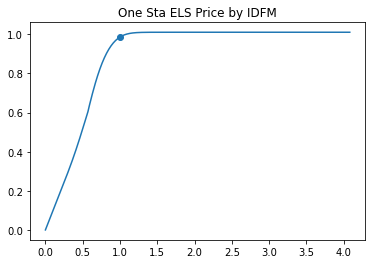

In [4]:
def ELS_OneStar_IFDM(xmin, xmax, rf, q, sigma, cr, K, B, dt, dx, N, M, x0tag, Rtag, Btag):
    u = np.zeros((N+1, M+1))   
    w = np.zeros((N+1, M+1))   
    xh = np.arange(M+1)
    x = xh*dx
    
    # Initial conditions at expiration, u is no knock-in case and w knock-in
    for i in range(M+1):
        if x[i] > B:
            u[0,i] = 1 + cr[-1]
        else:
            u[0,i] = x[i]
        if x[i] >= K[-1]:
            w[0,i] = 1 + cr[-1]
        else:
            w[0,i] = x[i]
    
    # Linear boundary conditions
    u[:,0] = 2*u[:,1] - u[:,2]
    u[:,M] = 2*u[:,M-1] - u[:,M-2]
    w[:,0] = 2*w[:,1] - w[:,2]
    w[:,M] = 2*w[:,M-1] - w[:,M-2]
    
    # IFDM coefficients
    a = 1 + dt*(rf + (sigma**2)*(xh**2))
    b = (dt/2)*((rf-q)*xh - (sigma**2)*(xh**2))
    c = -(dt/2)*((rf-q)*xh + (sigma**2)*(xh**2))
    
    # Adjustment by boundary conditions
    a[1] = a[1] + 2*b[1]
    c[1] = c[1] - b[1]
    a[M-1] = a[M-1] - c[M-1]
    b[M-1] = b[M-1] + 2*c[M-1]

    a = a[1:M]
    b = b[1:M]
    c = c[1:M]
    d = a

    for n in range (N):  
        for j in range(5):
            if n == Rtag[j]:
                dummy = int(x0tag*K[4-j])
                u[n,dummy:] = 1 + cr[4-j]
                w[n,dummy:] = 1 + cr[4-j]
        d = u[n,1:M]
        d[0] = d[0] - b[0]*u[n+1,0]
        d[M-2] = d[M-2] - c[M-2]*u[n+1,M]
        u[n+1,1:M] = Thomas_Algorithm(a,b,c,d)
        
        d = w[n,1:M]
        w[n+1,1:M] = Thomas_Algorithm(a,b,c,d)
        u[n+1,1:Btag]= w[n+1,1:Btag]
        
        u[n+1,0] = 2*u[n+1,1] - u[n+1,2]
        u[n+1,M] = 2*u[n+1,M-1] - u[n+1,M-2]
        w[n+1,0] = 2*w[n+1,1] - w[n+1,2]
        w[n+1,M] = 2*w[n+1,M-1] - w[n+1,M-2]
        
    return u

price = ELS_OneStar_IFDM(xmin, xmax, rf, q, sigma, cr, K, B, dt, dx, N, M, x0tag, Rtag, Btag)

print('One-Star ELS IFDM Price : ', "%.6f" %price[N,x0tag])
s = np.linspace(xmin, xmax, M+1)
plt.title('One Sta ELS Price by IDFM')
plt.plot(s, price[N,:])
plt.scatter(s[x0tag], price[N,x0tag])
plt.show()

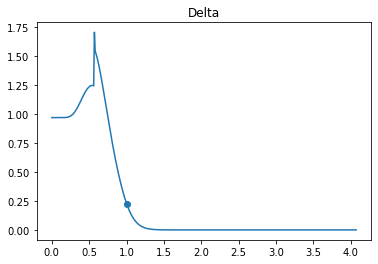

delta =  0.22810377274753435


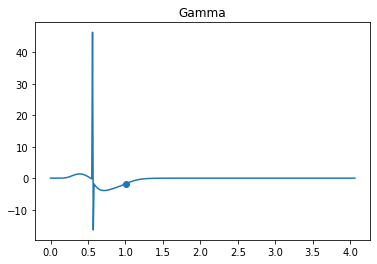

gamma =  -1.7926421505798373


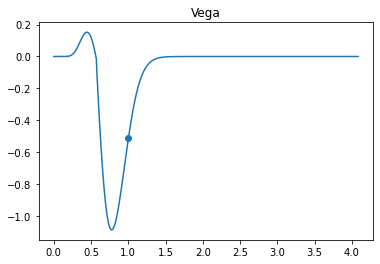

vega =  -0.5127900102567648


In [8]:
# Greeks

delta = (price[N,1:] - price[N,:-1])/dx
plt.title('Delta')
plt.plot(s[:-1], delta)
plt.scatter(s[x0tag], delta[x0tag])
plt.show()
print('delta = ', delta[x0tag])

gamma = (price[N,2:] - 2*price[N,1:-1] + price[N,:-2])/(dx**2)
plt.title('Gamma')
plt.plot(s[:-2], gamma)
plt.scatter(s[x0tag], gamma[x0tag])
plt.show()
print('gamma = ', gamma[x0tag])

dsig = sigma*0.01
vega = (ELS_OneStar_IFDM(xmin, xmax, rf, q, sigma, cr, K, B, dt, dx, N, M, x0tag, Rtag, Btag)[N,:]
        - ELS_OneStar_IFDM(xmin, xmax, rf, q, sigma-dsig, cr, K, B, dt, dx, N, M, x0tag, Rtag, Btag)[N,:])/dsig
plt.title('Vega')
plt.plot(s, vega)
plt.scatter(s[x0tag], vega[x0tag])
plt.show()
print('vega = ', vega[x0tag])

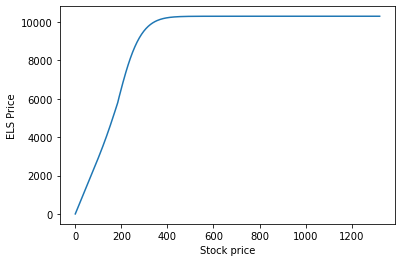

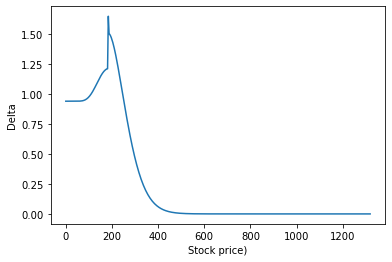

In [8]:
s = s*322.90
plt.plot(s, 10000*price[N,:])
plt.xlabel('Stock price')
plt.ylabel('ELS Price')
plt.show()

plt.plot(s[:-1], delta)
plt.xlabel('Stock price)')
plt.ylabel('Delta')
plt.show()